[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv8 Classification on a Custom Dataset

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/wuZtUMEiKWY)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

## ⚠️ Disclaimer

As of 11.01.2023, YOLOv8 Classification seems a tad underdeveloped. It is possible to train models, but their usability is questionable. Known problems include:
- The model pre-trained on the Imagenet dataset operates on the id of classes not their names. Only after custom post-processing can you find out how the image was classified. 
- No detailed training data available. At this point, it is almost standard to save information such as confusion matrix or graphs of key metrics after a training session is completed. YOLOv8 offers this feature but for the moment only for Object Detection and Instance Segmentation.
- In the case of the CLI, there is no saving of the prediction in text form. They are annotated on the image, which in practice makes it impossible to build any application using them.
- With SDK, a difficult-to-interpret matrix is returned instead of a vector of probabilities. Only after custom post-processing can you find out how the image was classified. 

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on how to train YOLOv8 Classification, concurrently.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv8
- CLI Basics
- Inference with Pre-trained COCO Model
- Roboflow Universe
- Preparing a custom dataset
- Custom Training
- Validate Custom Model
- Inference with Custom Model

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Wed Jan 11 11:14:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [ ]:
# Pip install (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()
!yolo mode=checks

Ultralytics YOLOv8.0.3 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.0/166.8 GB disk)


In [ ]:
# Git clone

# %cd {HOME}
# !git clone github.com/ultralytics/ultralytics
# %cd {HOME}/ultralytics
# !pip install -e ultralytics

# from IPython import display
# display.clear_output()
# !yolo mode=checks

In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics 

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started. Read more about CLI in [Ultralytics YOLO Docs](https://v8docs.ultralytics.com/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml    epochs=1 ...
          ...            ...            ...
          segment        predict        yolov8n-seg.pt
          classify        val           yolov8n-cls.pt
```

## Inference with Pre-trained COCO Model

### 💻 CLI

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

In [ ]:
%cd {HOME}
!yolo task=classify mode=predict model=yolov8n-cls.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg'

/content
100% 104k/104k [00:00<00:00, 6.08MB/s]
Ultralytics YOLOv8.0.3 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
100% 5.28M/5.28M [00:00<00:00, 13.9MB/s]

Fusing layers... 
YOLOv8n-cls summary: 73 layers, 2715880 parameters, 0 gradients, 4.3 GFLOPs
image 1/1 /content/dog.jpeg: 640x384 n01990800 1.00, n03207941 0.00, n02096437 0.00, n02823750 0.00, n04525038 0.00, 6.6ms
Speed: 1.5ms pre-process, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/classify/predict


In [ ]:
!ls runs/classify/predict/

dog.jpeg


/content


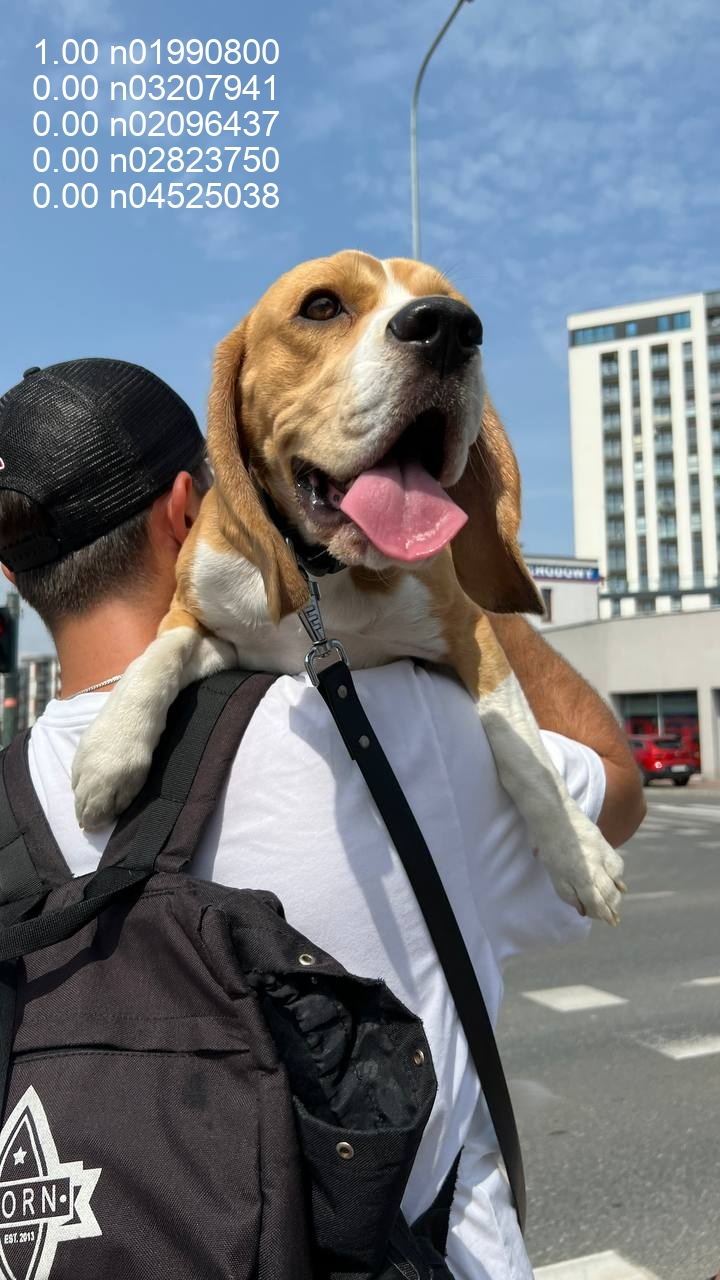

In [ ]:
%cd {HOME}
Image(filename='runs/classify/predict/dog.jpeg', height=600)

### 🐍 Python SDK

In [ ]:
model = YOLO(f'{HOME}/yolov8n-cls.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)

Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
Ultralytics YOLOv8.0.3 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
Fusing layers... 
YOLOv8n-cls summary: 73 layers, 2715880 parameters, 0 gradients, 4.3 GFLOPs
image 1/1 /content/dog.jpeg: 224x128 n01990800 1.00, n04525038 0.00, n02096437 0.00, n02606052 0.00, n02823750 0.00, 5.4ms
Speed: 0.4ms pre-process, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


## Roboflow Universe

Need data for your project? Before spending time on annotating, check out Roboflow Universe, a repository of more than 110,000 open-source datasets that you can use in your projects. You'll find datasets containing everything from annotated cracks in concrete to plant images with disease annotations.


[![Roboflow Universe](https://ik.imagekit.io/roboflow/notebooks/template/uni-banner-frame.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672878480290)](https://universe.roboflow.com/)



## Preparing a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let me show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Keep in mind to choose the right project type. In our case, Object Detection.

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/creating-project.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929799852"
  >
</div>

### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together. 

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/uploading-images.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929808290"
  >
</div>

### Step 3: Labeling

If you only have images, you can label them in [Roboflow Annotate](https://docs.roboflow.com/annotate).

<div align="center">
  <img
    width="640"
    src="https://user-images.githubusercontent.com/26109316/210901980-04861efd-dfc0-4a01-9373-13a36b5e1df4.gif"
  >
</div>

### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/generate-new-version.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1673003597834"
  >
</div>

### Step 5: Exporting dataset

Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training. Click `Export` and select the `YOLO v5 PyTorch` dataset format.

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/export.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672943313709"
  >
</div>




In [ ]:
%cd {HOME}

!pip install roboflow --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace("roboflow-universe-projects").project("banana-ripeness-classification")
dataset = project.version(4).download("folder")

/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 7.9 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Banana-Ripeness-Classification-4 in folder:: 100%|██████████| 13495/13495 [00:03<00:00, 3383.71it/s]


## Custom Training

In [ ]:
%cd {HOME}

!yolo task=classify mode=train model=yolov8n-cls.pt data={dataset.location} epochs=50 imgsz=128

/content
yolo/engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/Banana-Ripeness-Classification-4, epochs=50, patience=50, batch=16, imgsz=128, save=True, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, retina_masks=False, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, workspace=4, nms=False, lr0=0.1, lrf=0.01, momentum=0.937, weight_decay=5e-05, warmup_epoc

In [ ]:
!ls -la {HOME}/runs/classify/train/

total 1772
drwxr-xr-x 3 root root    4096 Jan 11 11:17 .
drwxr-xr-x 4 root root    4096 Jan 11 11:16 ..
-rw-r--r-- 1 root root    1349 Jan 11 11:16 args.yaml
-rw-r--r-- 1 root root 1779440 Jan 11 11:55 events.out.tfevents.1673435799.8e76317367da.792.0
-rw-r--r-- 1 root root    9792 Jan 11 11:55 results.csv
drwxr-xr-x 2 root root    4096 Jan 11 11:17 weights


In [ ]:
!cat {HOME}/runs/classify/train/results.csv | head -10

                  epoch,             train/loss,  metrics/accuracy_top1,  metrics/accuracy_top5,               val/loss,                 lr/pg0,                 lr/pg1,                 lr/pg2
                      0,                0.26657,                 0.7242,                      1,                0.69499,                    0.1,                    0.1,                    0.1
                      1,                0.17981,                0.83452,                      1,                0.41385,                    0.1,                    0.1,                    0.1
                      2,                0.15695,                0.86477,                      1,                0.39399,                0.09802,                0.09802,                0.09802
                      3,                0.14038,                0.89146,                      1,                0.32446,                0.09604,                0.09604,                0.09604
                      4,                

## Validate Custom Model

In [ ]:
%cd {HOME}

!yolo task=classify mode=val model={HOME}/runs/classify/train/weights/best.pt data={dataset.location}

/content
Ultralytics YOLOv8.0.3 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
Fusing layers... 
YOLOv8n-cls summary: 73 layers, 1440004 parameters, 0 gradients, 3.3 GFLOPs
albumentations: RandomResizedCrop(p=1.0, height=640, width=640, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1), HorizontalFlip(p=0.5), ColorJitter(p=0.5, brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[0, 0]), Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0), ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
               classes   top1_acc   top5_acc: 100% 36/36 [00:08<00:00,  4.25it/s]
                   all      0.726          1
Speed: 0.5ms pre-process, 2.4ms inference, 0.0ms loss, 0.0ms post-process per image


## Inference with Custom Model

In [ ]:
%cd {HOME}
!yolo task=classify mode=predict model={HOME}/runs/classify/train/weights/best.pt conf=0.25 source={dataset.location}/test/overripe

/content
Ultralytics YOLOv8.0.3 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
Fusing layers... 
YOLOv8n-cls summary: 73 layers, 1440004 parameters, 0 gradients, 3.3 GFLOPs
image 1/113 /content/Banana-Ripeness-Classification-4/test/overripe/musa-acuminata-mold-e18cfd23-1d0a-11ec-87d5-d8c4975e38aa_jpg.rf.175dccdf3479ad6a73213197efe00527.jpg: 128x128 overripe 0.78, ripe 0.22, rotten 0.00, unripe 0.00, 4.8ms
image 2/113 /content/Banana-Ripeness-Classification-4/test/overripe/musa-acuminata-mold-e1a4d2b8-1d0a-11ec-af1f-d8c4975e38aa_jpg.rf.49b2874813b9606a2e643b694212cfc1.jpg: 128x128 overripe 0.97, ripe 0.03, rotten 0.00, unripe 0.00, 3.2ms
image 3/113 /content/Banana-Ripeness-Classification-4/test/overripe/musa-acuminata-mold-e1ae5b43-1d0a-11ec-80fd-d8c4975e38aa_jpg.rf.e3757cdfe9a0f7a6a659b6e6858e3a2a.jpg: 128x128 overripe 0.85, ripe 0.15, rotten 0.00, unripe 0.00, 3.2ms
image 4/113 /content/Banana-Ripeness-Classification-4/test/overripe/musa-acuminata-mold-e1de067f-1d0a-1

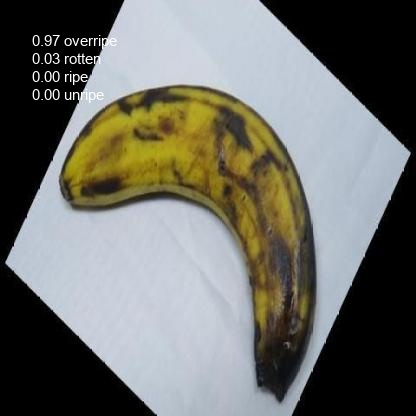

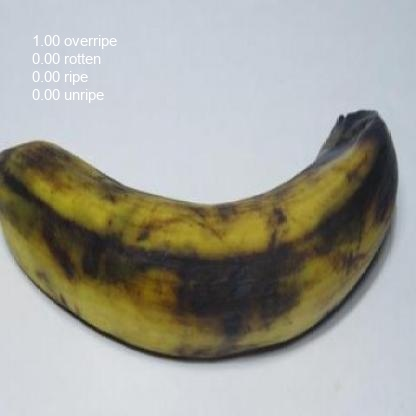

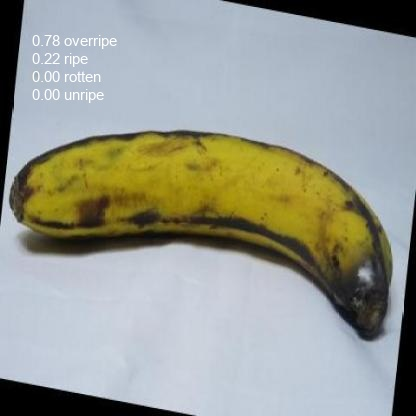

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/classify/predict3/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.